In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from pathlib import Path

In [12]:
# Dataset
DATASET_DIR = './multi-cancer'
CANCER_TYPE = "Lung and Colon Cancer"

# Image
H, W = 224, 224
MEAN = torch.tensor([0.7283, 0.5995, 0.8760])
STD = torch.tensor([0.1327, 0.1738, 0.0679])

# Training
BATCH_SIZE = 32

TRAIN_PHASE1 = False
TRAIN_PHASE2 = False
TRAIN_PHASE3 = False

PHASE1_EPOCHS = 10
PHASE2_EPOCHS = 20
PHASE3_EPOCHS = 5

PHASE1_PATIENCE = 3
PHASE2_PATIENCE = 5

CRITERION = nn.CrossEntropyLoss()

PHASE1_LR = 1e-3
PHASE2_LR = 1e-4
PHASE3_LR = 1e-5

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [15]:
cancer_dir = os.path.join(DATASET_DIR, CANCER_TYPE)
class_names = sorted([d for d in os.listdir(cancer_dir) 
                      if os.path.isdir(os.path.join(cancer_dir, d))])
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

print("Classes:", class_names)
print("Class to index:", class_to_idx)

image_paths = []
image_labels = []
class_counts = {cls_name: 0 for cls_name in class_names}

for class_name in class_names:
    class_dir = os.path.join(cancer_dir, class_name)
    for filename in os.listdir(class_dir):
        path = os.path.join(class_dir, filename)
        if os.path.isfile(path):
            image_paths.append(path)
            image_labels.append(class_to_idx[class_name])
            class_counts[class_name] += 1

Classes: ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Class to index: {'colon_aca': 0, 'colon_bnt': 1, 'lung_aca': 2, 'lung_bnt': 3, 'lung_scc': 4}


In [16]:
# Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')
print("Total image count:", len(image_paths))
print("\nClass distribution:")
for cls_name, count in class_counts.items():
    print(f"  {cls_name}: {count}")
print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['./multi-cancer\\Lung and Colon Cancer\\lung_aca\\lung_aca_3885.jpg', './multi-cancer\\Lung and Colon Cancer\\colon_bnt\\colon_bnt_4517.jpg', './multi-cancer\\Lung and Colon Cancer\\lung_aca\\lung_aca_2098.jpg', './multi-cancer\\Lung and Colon Cancer\\lung_aca\\lung_aca_3883.jpg', './multi-cancer\\Lung and Colon Cancer\\colon_bnt\\colon_bnt_1534.jpg'] 

[2, 1, 2, 2, 1] 

Total image count: 25000

Class distribution:
  colon_aca: 5000
  colon_bnt: 5000
  lung_aca: 5000
  lung_bnt: 5000
  lung_scc: 5000
Image size: (512, 512)
Image mode: RGB


In [17]:
#train, val, test = 70%, 15%, 15%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print("Training size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Testing size:", len(test_paths))

Training size: 17500
Validation size: 3750
Testing size: 3750


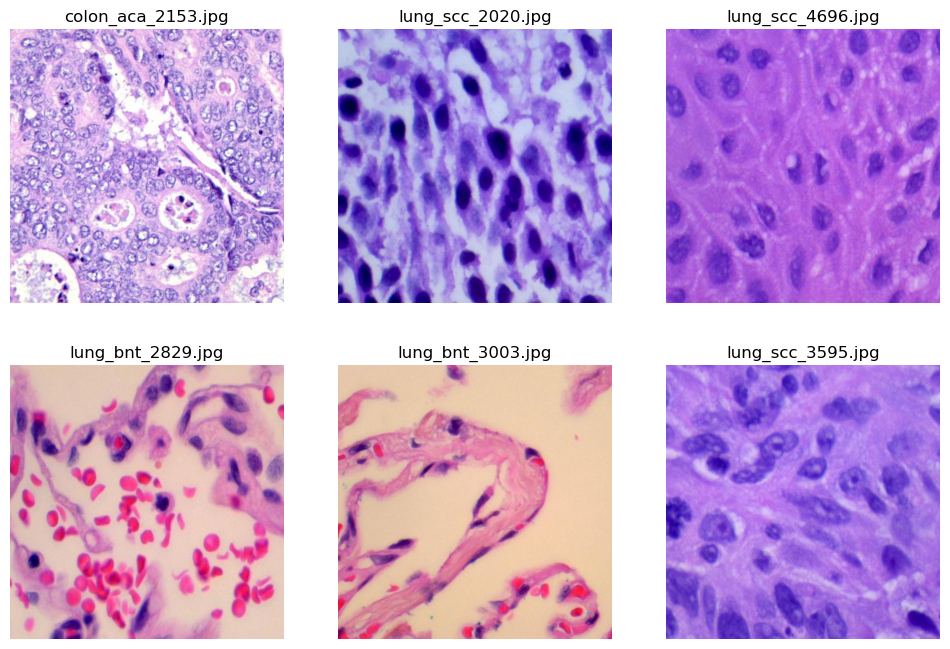

In [18]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [19]:
# # Calculate Mean and Standard Deviation of the training set
# transform = transforms.Compose([
#     transforms.Resize((H, W)),
#     transforms.ToTensor()
# ])

# mean = 0.
# std = 0.
# n = 0

# for path in tqdm(train_paths):
#     img = Image.open(path).convert('RGB')
#     img = transform(img)  # shape: [3, H, W]
#     mean += img.mean(dim=[1,2])
#     std += img.std(dim=[1,2])
#     n += 1

# mean /= n
# std /= n

# print("Mean:", mean)
# print("Std:", std)

In [20]:
#Data augmentation 
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [21]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# For train_loader, val_loader and test_loader
# There are approximately len({}_paths) / BATCH_SIZE batches in total
# Each batch has a shape of [BATCH_SIZE, 3, H, W]
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Training", leave=False)

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

        current_loss = total_loss / total_samples
        current_acc = total_correct / total_samples
        loop.set_postfix(loss=current_loss, acc=current_acc)

    return total_loss / total_samples, total_correct / total_samples

In [23]:
@torch.no_grad()
def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    loop = tqdm(dataloader, desc="Validating", leave=False)

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += batch_size

        current_loss = total_loss / total_samples
        current_acc = total_correct / total_samples
        loop.set_postfix(loss=current_loss, acc=current_acc)

    return total_loss / total_samples, total_correct / total_samples

In [24]:
def save_checkpoint(model, optimizer, epoch, val_acc, train_losses, val_losses, save_path):
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "val_acc": val_acc,
        "train_losses": train_losses,
        "val_losses": val_losses
    }, save_path)

    print(f"[Checkpoint Saved] epoch={epoch}, acc={val_acc:.4f} → {save_path}")

def load_checkpoint(model, optimizer, path, device):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No checkpoint found at '{path}'")

    ckpt = torch.load(path, map_location=device)

    model.load_state_dict(ckpt["model_state_dict"])

    if optimizer is not None:
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])

    start_epoch = ckpt.get("epoch", 0)
    best_val_acc = ckpt.get("val_acc", 0.0)

    train_losses = ckpt.get("train_losses", [])
    val_losses = ckpt.get("val_losses", [])

    print(f"[Checkpoint Loaded] epoch={start_epoch}, best_acc={best_val_acc:.4f}")
    return model, optimizer, start_epoch, best_val_acc, train_losses, val_losses

In [25]:
@torch.no_grad()
def evaluate_on_test(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = (all_preds == all_labels).mean()
    print(f"\nTest Accuracy: {acc:.4f}")

    if class_names is None:
        class_names = ["normal", "SCC"]

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names,
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Set)")
    plt.tight_layout()
    plt.show()

### Phase 1: Train with frozen backbone

In [26]:
NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES) # type: ignore

for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=PHASE1_LR, weight_decay=1e-4)

Number of classes: 5


In [27]:
best_val_acc = 0.0

checkpoint_dir = Path('checkpoints') / CANCER_TYPE.lower().replace(" ", "_") / 'phase1'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE1:
    train_losses = []
    val_losses = []
    start_epoch = 0
    patience_counter = 0

    for epoch in range(PHASE1_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, CRITERION, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, CRITERION, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"[Epoch {epoch+1}/{PHASE1_EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(model, optimizer, epoch + 1, best_val_acc, train_losses, val_losses, checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PHASE1_PATIENCE:
                print("Early stopping triggered.")
                break
else:
    model, optimizer, start_epoch, best_val_acc, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

[Checkpoint Loaded] epoch=5, best_acc=0.9701


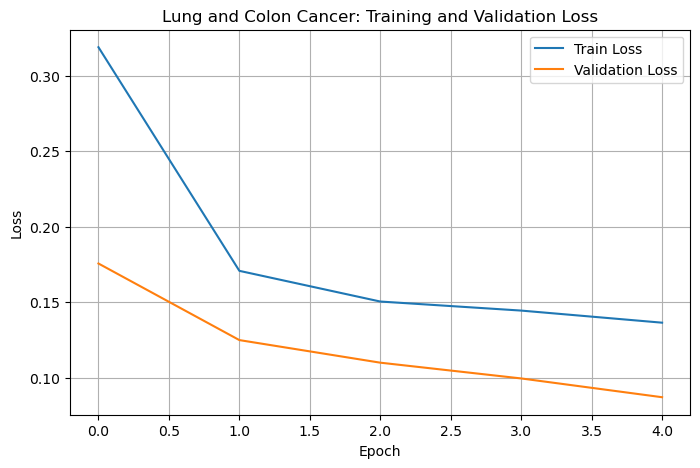

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(CANCER_TYPE + ': Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Phase 2: Fine-tune with partially unfrozen backbone

In [29]:
for param in model.features.parameters():
    param.requires_grad = False


num_blocks = len(model.features)
for idx in range(num_blocks - 3, num_blocks):
    for param in model.features[idx].parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=PHASE2_LR, weight_decay=1e-4)

In [30]:
checkpoint_dir = Path('checkpoints') / CANCER_TYPE.lower().replace(" ", "_") / 'phase2'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE2:
    train_losses = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(PHASE2_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, CRITERION, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, CRITERION, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"[Phase2 Epoch {epoch+1}/{PHASE2_EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_checkpoint(model, optimizer, epoch + 1, best_val_acc, train_losses, val_losses, checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PHASE2_PATIENCE:
                print("Early stopping triggered.")
                break
else:
    model, optimizer, start_epoch, best_val_acc, train_losses, val_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

[Checkpoint Loaded] epoch=7, best_acc=1.0000


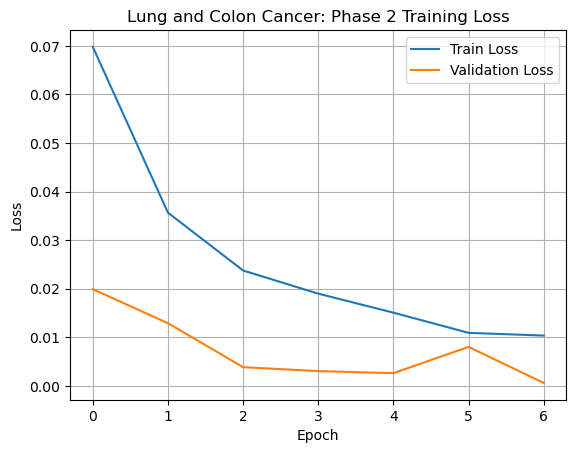

In [31]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(CANCER_TYPE + ': Phase 2 Training Loss')
plt.legend()
plt.grid(True)
plt.show()

### Phase 3: Final training with combined data (train + val)

In [32]:
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [33]:
for param in model.parameters():
    param.requires_grad = True

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=PHASE3_LR, weight_decay=1e-4)

In [38]:
checkpoint_dir = Path('checkpoints') / CANCER_TYPE.lower().replace(" ", "_") / 'phase3'
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "best_model.pth"

if TRAIN_PHASE3:
    combined_losses = []
    test_losses = []
    test_accs = []
    best_test_acc = 0.0

    for epoch in range(PHASE3_EPOCHS):
        combined_loss, combined_acc = train_one_epoch(model, combined_loader, optimizer, CRITERION, device)
        test_loss, test_acc = eval_one_epoch(model, test_loader, CRITERION, device)

        combined_losses.append(combined_loss)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
        
        print(f"[Phase3 Epoch {epoch+1}/{PHASE3_EPOCHS}] "
              f"Train Loss: {combined_loss:.4f}, Acc: {combined_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    save_checkpoint(model, optimizer, epoch + 1, best_test_acc, combined_losses, test_losses, checkpoint_path)
else:
    model, optimizer, start_epoch, best_test_acc, combined_losses, test_losses = load_checkpoint(model, optimizer, checkpoint_path, device)

[Checkpoint Loaded] epoch=5, best_acc=0.0000


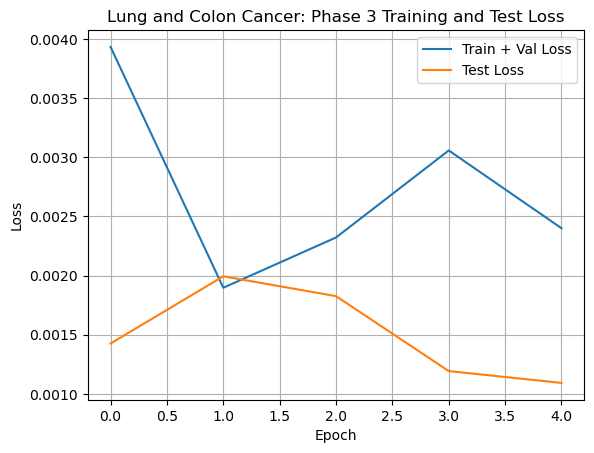

In [40]:
plt.plot(combined_losses, label='Train + Val Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(CANCER_TYPE + ': Phase 3 Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation

Class names: ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']


Testing: 100%|██████████| 118/118 [00:54<00:00,  2.16it/s]



Test Accuracy: 0.9995

Classification Report:
              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       750
   colon_bnt       1.00      1.00      1.00       750
    lung_aca       1.00      1.00      1.00       750
    lung_bnt       1.00      1.00      1.00       750
    lung_scc       1.00      1.00      1.00       750

    accuracy                           1.00      3750
   macro avg       1.00      1.00      1.00      3750
weighted avg       1.00      1.00      1.00      3750



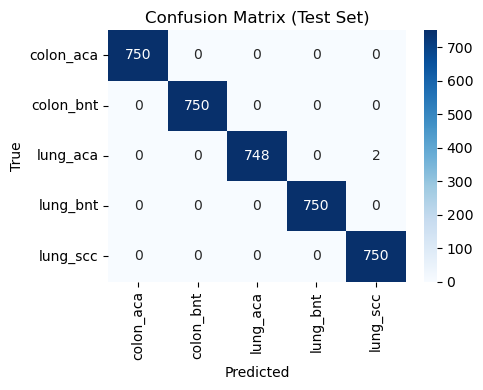

In [ ]:
print("Class names:", class_names)
evaluate_on_test(model, test_loader, device, class_names=class_names)